In [1]:
%matplotlib inline

In [2]:
import os
import shutil

import time
import datetime

import numpy as np
np.random.seed(42)

import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, PReLU, LeakyReLU, BatchNormalization, Add, Flatten, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy

from tensorflow.keras.applications import vgg19

import skimage.draw
from skimage.io import imshow

# Text Localization

## Failing to do GAN :(

Several papers inspired this project. 

* "Image-to-Image Translation with Conditional Adversarial Networks", Phillip Isola, Jun-Yan Zhu, Tinghui Zhou, Alexei A. Efros, 2018, https://arxiv.org/pdf/1611.07004.pdf

* "TLGAN: Document Text Localization Using GAN", Dongyoung Kim, Myungsung Kwak, Eunji Won, Sejung Shin, Jeongyeon Nam, 2020, https://arxiv.org/pdf/2010.11547.pdf

* "Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network", C. Ledig, L. Theis, F. Huszar, J. Caballero, A. Cunningham, A. Acosta, A. Aitken, A. Tejani, J. Totz, Z. Wang, and W. Shi, 2016, https://arxiv.org/pdf/1609.04802.pdf


Unfortunately as time closed in results remained inconclusive..

I couldn't produce any satisfactory results no matter how much I tweaked the architectures and the training steps.\
Such a project probably requires much more time to get running properly and it was infeasible to do this in a week or two.

In any case here I have documented the process I went through so far.

In [3]:
BASE_TRAIN_DIR = "./receipt_data/task_1_train"

TRAIN_PCT = .80
VAL_PCT = .10

In [4]:
def read_folder(path):
    result = set()
    
    for file_name in os.listdir(path):
        if "(" in file_name: continue # Skips duplicates
        if "_" in file_name: continue # Skips images created by us (preprocessing)
        if "normalized" in file_name: continue # Skips images created by us (preprocessing)

        base_name, _ = os.path.splitext(file_name)
        result.add(os.path.join(path, base_name))

    return list(result)

In [5]:
train_images = read_folder(BASE_TRAIN_DIR)

In [6]:
def train_val_test_split(images):
    images = list(images)
    train_end_index = round(len(images) * TRAIN_PCT)
    val_end_index = train_end_index + round(len(images) * VAL_PCT)
    train = images[:train_end_index]
    val = images[train_end_index:val_end_index]
    test = images[val_end_index:]
    return train, val, test

In [7]:
train_data, val_data, test_data = train_val_test_split(train_images)

The generator model is a U-Net like architecture. [[1]](https://arxiv.org/pdf/1611.07004.pdf) [[2]](https://arxiv.org/pdf/2010.11547.pdf)

In [8]:
TRAIN_IMAGE_WIDTH = 436
TRAIN_IMAGE_HEIGHT = 605

In [9]:
tf.keras.backend.clear_session()

In [10]:
def residual_block(x):
    y = Conv2D(64, kernel_size = (3, 3), padding = "same")(x)
    y = BatchNormalization()(y)
    y = LeakyReLU()(y)
    y = Conv2D(64, kernel_size = (3, 3), padding = "same")(y)
    y = BatchNormalization()(y)
    out = Add()([x, y])
    return out

In [11]:
def create_generator_model(num_residual_blocks):
    inputs = Input(shape = (TRAIN_IMAGE_HEIGHT, TRAIN_IMAGE_WIDTH, 3))
    
    # Pre-residual block
    x = Conv2D(64, kernel_size = (9, 9), padding = "same")(inputs)
    x = LeakyReLU()(x)

    # Residual blocks
    y = x
    for _ in range(num_residual_blocks):
        y = residual_block(y)

    # Post-residual block
    y = Conv2D(64, kernel_size = (3, 3), padding = "same")(y)
    y = BatchNormalization()(y)
    y = Add()([x, y])

    # Generate text map image with final conv layer with sigmoid activation for each pixel
    y = Conv2D(128, kernel_size = (3, 3), padding = "same")(y)
    y = LeakyReLU()(y)
    outputs = Conv2D(1, kernel_size = (9, 9), padding = "same", activation = tf.nn.sigmoid)(y)

    return Model(inputs, outputs)

In [12]:
#generator_model = create_generator_model(num_residual_blocks = 4)
#generator_model.compile()
#generator_model.summary()

Load a model we saved earlier (so we get the same weights). We used that same model to generate the "fake" images when training the discriminator.

In [13]:
generator_model = tf.keras.models.load_model("generator_untrained")

The [authors of the paper](https://arxiv.org/pdf/1611.07004.pdf) described using `LAMBDA = 100`.

In [18]:
LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error between the target images (preserves structure in the image)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss, gan_loss, l1_loss

In [19]:
loss_object = tf.keras.losses.BinaryCrossentropy()

In [20]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

In [21]:
discriminator_model = tf.keras.models.load_model("discriminator_new_arch_trained")

Tweaking the optimizer didn't make much sense. Several papers with related work confirm that Adam performs the best. But also we couldn't even overfit one sample image... soo...

In [22]:
generator_optimizer = Adam()
discriminator_optimizer = Adam()

In [23]:
checkpoint_prefix = os.path.join("./gan_checkpoints", "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator_model,
                                 discriminator = discriminator_model)

In [24]:
DISCRIMINATOR_WIDTH = 128
DISCRIMINATOR_HEIGHT = 128

In [25]:
log_dir = "logs/"
summary_writer = tf.summary.create_file_writer(log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [26]:
@tf.function
def train_step(input_image, target, epoch):    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Predict generator
        gen_output = generator_model(input_image, training = True)
        
        # Predict discriminator
        input_image_for_disc = tf.image.resize(input_image, (DISCRIMINATOR_HEIGHT, DISCRIMINATOR_WIDTH))
        disc_real_output = discriminator_model(input_image_for_disc, training = True)

        # Resize the gen_output to 128x128 and convert to rgb (our discriminator uses VGG19)
        gen_output_for_disc = tf.image.grayscale_to_rgb(gen_output)
        gen_output_for_disc = tf.image.resize(gen_output_for_disc, (DISCRIMINATOR_HEIGHT, DISCRIMINATOR_WIDTH))
        disc_generated_output = discriminator_model(gen_output_for_disc, training = True)
        
        # Calculate losses
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
        
        # ..gradients
        generator_gradients = gen_tape.gradient(gen_total_loss, generator_model.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss, discriminator_model.trainable_variables)
        
        # Apply
        generator_optimizer.apply_gradients(zip(generator_gradients, generator_model.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator_model.trainable_variables))
        
    with summary_writer.as_default():
        tf.summary.scalar("gen_total_loss", gen_total_loss, step = epoch)
        tf.summary.scalar("gen_gan_loss", gen_gan_loss, step = epoch)
        tf.summary.scalar("gen_l1_loss", gen_l1_loss, step = epoch)
        tf.summary.scalar("disc_loss", disc_loss, step = epoch)

In [27]:
def fit(train_dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for example_input, example_target in train_dataset.take(1):
            show_images(generator_model, example_input, example_target)
        print("Epoch: ", epoch)

        # Train
        for (input_image, target) in train_dataset:
            print(".", end = "")
            train_step(input_image, target, epoch)
        print()

        # Saving (checkpoint) the model every 20 epochs
        if (epoch + 1) % 20 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print(f"Time taken for epoch {epoch + 1} is {time.time() - start} sec\n")
    checkpoint.save(file_prefix = checkpoint_prefix)

`show_images` function allows us to visualize side by side the input image, the target image (ground truth) and what the generator predicts.

In [28]:
def show_images(model, test_input, target):
    prediction = model(test_input, training = True)
    
    title = ["Input Image", "Ground Truth", "Predicted Image"]
    display_list = [test_input[0] * 0.5 + 0.5, target[0], prediction[0]]

    plt.figure(figsize = (15, 15))
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(np.squeeze(display_list[i]))
        plt.axis("off")
    plt.show()

We load a very small subsample of images into memory so this is still not a problem (like before).

In [29]:
def read_images_into_memory(paths):
    X = np.zeros((len(paths), TRAIN_IMAGE_HEIGHT, TRAIN_IMAGE_WIDTH, 3), dtype = np.float32)
    y = np.zeros((len(paths), TRAIN_IMAGE_HEIGHT, TRAIN_IMAGE_WIDTH, 1)).astype(np.float32)

    for i, path in enumerate(paths):
        print(path)
        print(f"{i + 1}/{len(paths)}")
        
        X[i] = np.load(path + "_normalized.npy")
        
        img_raw = tf.io.read_file(path + "_target.jpg")
        y[i] = tf.io.decode_jpeg(img_raw)
        y[i] /= 255 # Transform pixel values from 0-255 to 0-1.
    return X, y

In [30]:
# del X_train, y_train, X_test, y_test

In [31]:
X_train, y_train = read_images_into_memory(train_data[:10])
X_test, y_test = read_images_into_memory(test_data[:10])

./receipt_data/task_1_train/X51006619342
1/10
./receipt_data/task_1_train/X51006414721
2/10
./receipt_data/task_1_train/X51005441408
3/10
./receipt_data/task_1_train/X51006557198
4/10
./receipt_data/task_1_train/X51007843145
5/10
./receipt_data/task_1_train/X51006857071
6/10
./receipt_data/task_1_train/X51008164992
7/10
./receipt_data/task_1_train/X51005711451
8/10
./receipt_data/task_1_train/X51006620190
9/10
./receipt_data/task_1_train/X51006555814
10/10
./receipt_data/task_1_train/X51006619854
1/10
./receipt_data/task_1_train/X51006912960
2/10
./receipt_data/task_1_train/X51005442346
3/10
./receipt_data/task_1_train/X51005719917
4/10
./receipt_data/task_1_train/X51006466055
5/10
./receipt_data/task_1_train/X51007846325
6/10
./receipt_data/task_1_train/X51006414675
7/10
./receipt_data/task_1_train/X51007419197
8/10
./receipt_data/task_1_train/X51006008091
9/10
./receipt_data/task_1_train/X51006332649
10/10


In [32]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((10, 605, 436, 3), (10, 605, 436, 1), (10, 605, 436, 3), (10, 605, 436, 1))

In [33]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(1)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(1)

In [34]:
EPOCHS = 100

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


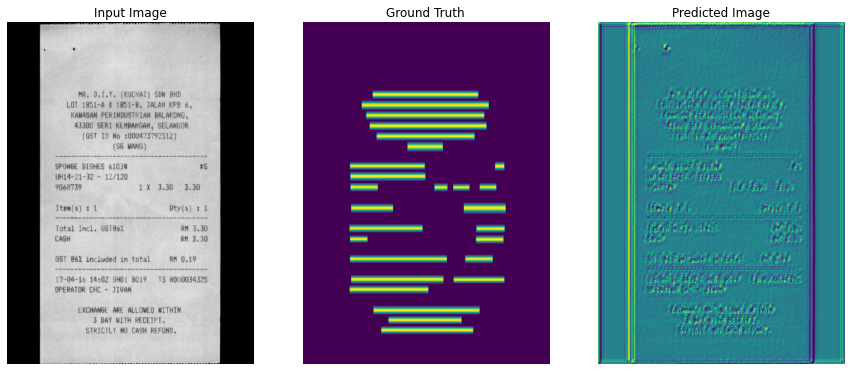

Epoch:  0
..........
Time taken for epoch 1 is 93.82259559631348 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


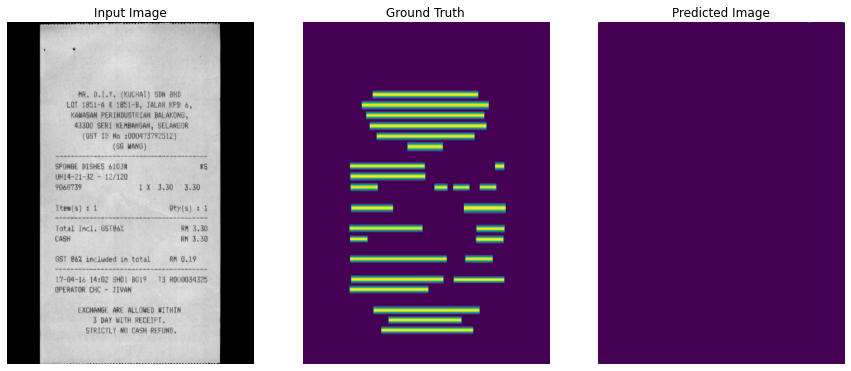

Epoch:  1
..........
Time taken for epoch 2 is 102.00683927536011 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


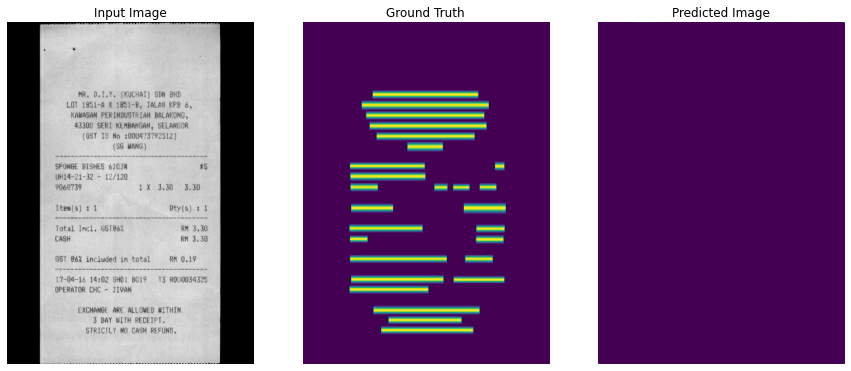

Epoch:  2
..........
Time taken for epoch 3 is 103.72057557106018 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


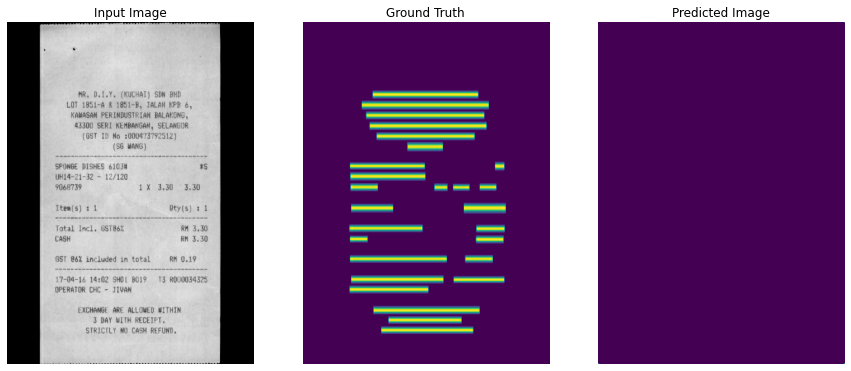

Epoch:  3
..........
Time taken for epoch 4 is 103.77522277832031 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


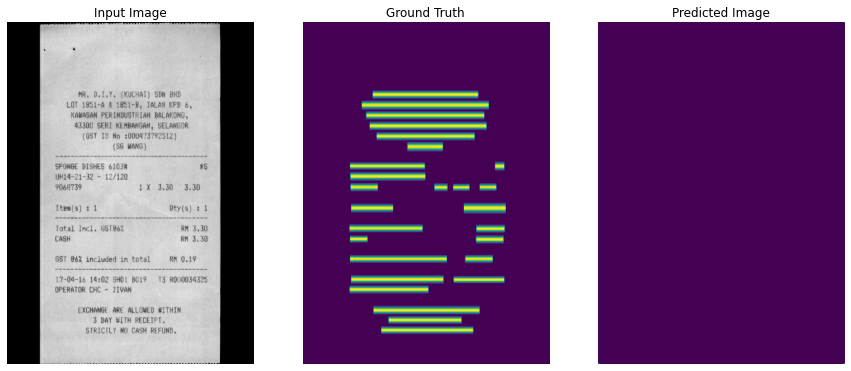

Epoch:  4
..........
Time taken for epoch 5 is 93.84152460098267 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


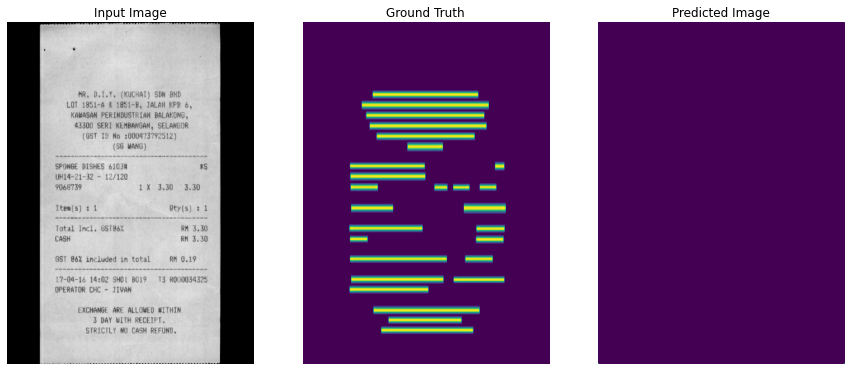

Epoch:  5
..........
Time taken for epoch 6 is 91.5066077709198 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


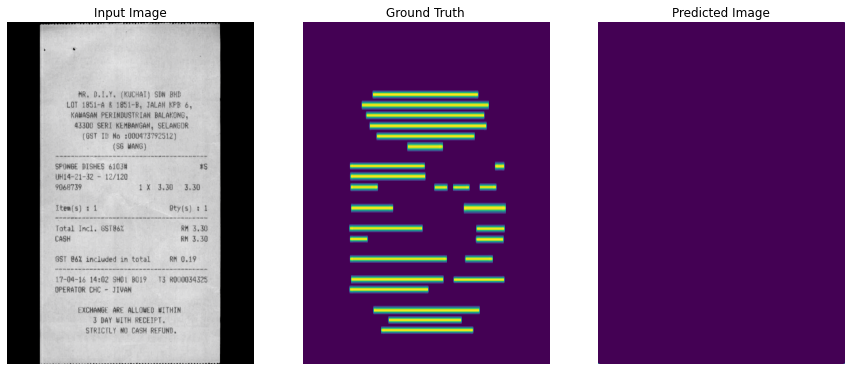

Epoch:  6
..........
Time taken for epoch 7 is 91.759765625 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


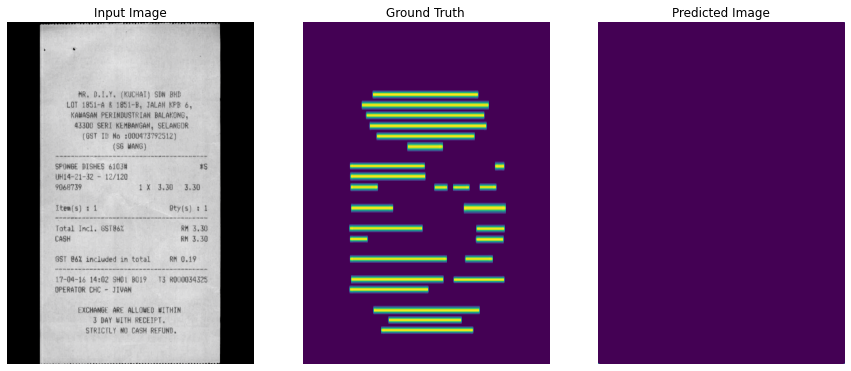

Epoch:  7
..........
Time taken for epoch 8 is 91.98605275154114 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


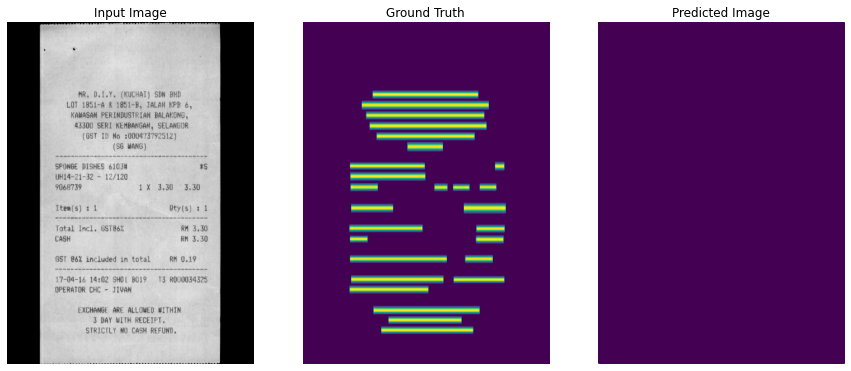

Epoch:  8
......

KeyboardInterrupt: 

In [35]:
fit(train_dataset, EPOCHS)

In [39]:
!ls "logs/fit/20210225-205812"

events.out.tfevents.1614286692.repertoire-gpu.5203.10672.v2


## Other references

* "How to Train a GAN? Tips and tricks to make GANs work", https://github.com/soumith/ganhacks
* "GAN by Example using Keras on Tensorflow Backend", https://towardsdatascience.com/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0